In [1]:
import sys

sys.path.append("../")

from src.common_functions import *
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss

# 1. Load data, prep & train test split

In [3]:
df = pd.read_csv("../datasets/churn/fin_churn.csv" )
df = df.rename(columns=dict(zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
RAW_DATA_PATH = "../datasets/churn/fin_churn.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
num_rows = len(df)
print(f'The dataset has {num_rows} rows.')

The dataset has 10000 rows.


In [6]:
df.exited.value_counts()/df.shape[0]*100

exited
0    79.63
1    20.37
Name: count, dtype: float64

In [7]:
70.63/20.37

3.467353951890034

In [8]:
20.37/70.63

0.28840436075322107

In [9]:
df.isna().any()

row_number          False
customer_id         False
surname             False
credit_score        False
geography           False
gender              False
age                 False
tenure              False
balance             False
num_of_products     False
has_cr_card         False
is_active_member    False
estimated_salary    False
exited              False
dtype: bool

In [10]:
y = "exited"

# some generic cleaning

COLUMNS_TO_DROP = ["customer_id", "surname"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [11]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train['exited']),
                                        y = train['exited']                                                    
                                    )
class_weights = dict(zip(np.unique(train['exited']), class_weights))
class_weights

{0: 0.6279434850863422, 1: 2.4539877300613497}

In [12]:

param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [6,8,10,12],
#     'under__sampling_strategy': [0.3, 0.5, 0.7, 1],
#     'over__sampling_strategy': [0.5, 0.7, 1]
 'logistic__class_weight': [{0:0.6279434850863422 , 1: 2.4539877300613497}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose=1,step_names_to_remove=['under', 'over'])
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 64 candidates, totalling 320 fits


Best score: 0.7722592482014041
Best parameters: {'logistic__C': 10, 'logistic__class_weight': {0: 1, 1: 10}, 'logistic__penalty': 'l2', 'pca__n_components': 12}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['row_number', 'credit_score',
                                                   'age', 'tenure', 'balance',
                                                   'num_of_products',
                                                   'has_cr_card',
                                                   'is_active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['geography', 'gender'])])),
                ('pca', PCA(n_components=12)),
                ('logistic',
                 LogisticRegression(C=10, class_weight={0: 1, 1: 10}))])

In [13]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

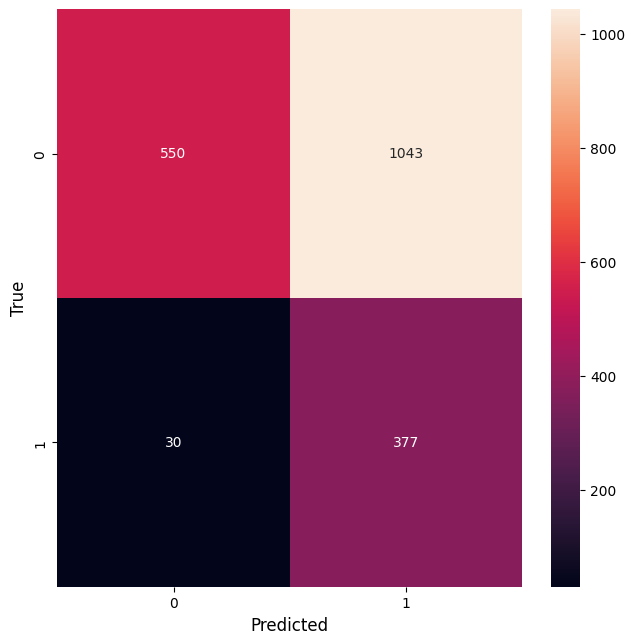

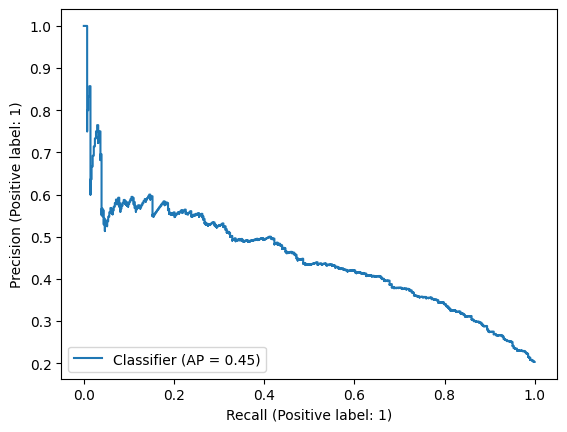

In [14]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name='logistic')

In [15]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

In [16]:
num_positive = np.sum(train == 1)
num_negative = np.sum(train == 0)
scale_pos_weight = num_negative / num_positive
print(scale_pos_weight)

row_number          0.000000
credit_score             NaN
geography                NaN
gender                   NaN
age                      NaN
tenure              0.396864
balance                  inf
num_of_products     0.000000
has_cr_card         0.416431
is_active_member    0.927246
estimated_salary         NaN
exited              3.907975
dtype: float64


In [17]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [14, 20, 25, 30, 35, 50, 65],
    # 'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    # 'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
    'xgb__scale_pos_weight':[ 1,3.907975, 10, 50, 75, 100,  1000]
    
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized= True,step_names_to_remove=['under', 'over'])
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.8518486771773363
Best parameters: {'xgb__subsample': 1.0, 'xgb__scale_pos_weight': 1, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 5, 'xgb__max_depth': 4, 'xgb__gamma': 5, 'xgb__colsample_bytree': 1.0, 'pca__n_components': 14}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['row_number', 'credit_score',
                                                   'age', 'tenure', 'balance',
                                                   'num_of_products',
                                                   'has_cr_card',
                                                   'is_active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strate...
                               feature_types=None, gamma=5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [18]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

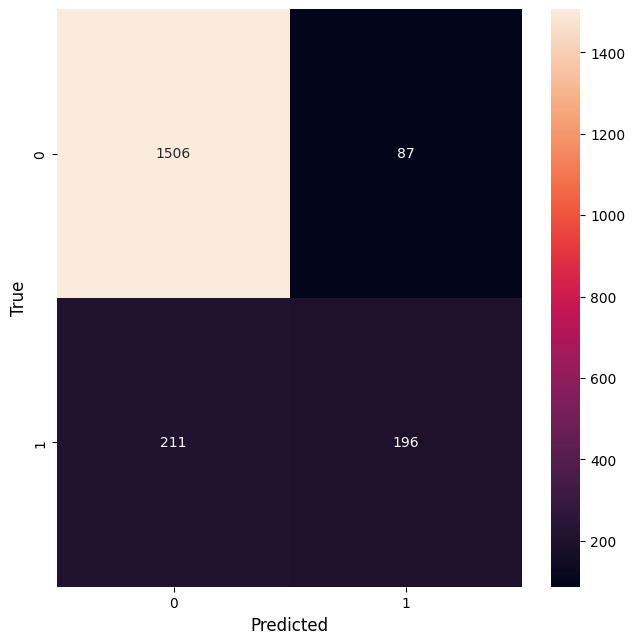

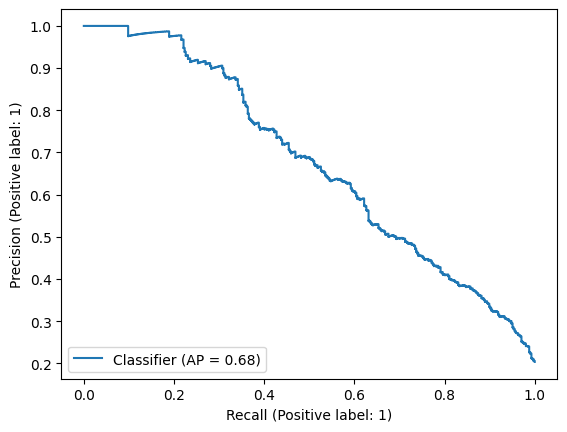

In [19]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [20]:
MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# cost evaluation metrics

In [21]:
test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log["churn_encoded"] = fit_le.transform(test_predictions_log["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test_predictions_log["balance"]*test_predictions_log["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))

Test cost/loss = 731.
 total cost/loss average :  0.3656937564017559


In [22]:
print(test_predictions_log[['exited', "A", 'instance_cost', 'y_predicted']].iloc[31:60])
print(test[y])

      exited         A  instance_cost  y_predicted
1690       0  0.208530       0.000000            0
6514       0  0.000000       0.000000            0
5741       0  0.479974       0.959949            1
4478       0  0.000000       0.000000            0
3729       0  0.000000       0.000000            0
6626       0  0.598616       1.197232            1
9089       0  0.308224       0.616448            1
1868       0  0.366322       0.000000            0
6676       0  0.000000       0.000000            1
8241       0  0.000000       0.000000            0
9441       0  0.359994       0.719987            1
9690       1  0.687904       8.254851            0
5032       0  0.402149       0.804297            1
2381       1  0.630841       0.000000            1
2112       0  0.000000       0.000000            1
2025       0  0.000000       0.000000            1
9118       0  0.000000       0.000000            0
1525       0  0.454388       0.908777            1
4250       0  0.327531       0.

In [23]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["balance"]*test_predictions_xgb["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))

Test cost/loss = 899.
 total cost/loss average :  0.4493190590931387


In [24]:
print(test_predictions_xgb[['exited', "A", 'instance_cost', 'y_predicted']].iloc[31:60])
print(test[y])

      exited         A  instance_cost  y_predicted
1690       0  0.208530       0.000000            0
6514       0  0.000000       0.000000            0
5741       0  0.479974       0.000000            0
4478       0  0.000000       0.000000            0
3729       0  0.000000       0.000000            0
6626       0  0.598616       0.000000            0
9089       0  0.308224       0.000000            0
1868       0  0.366322       0.000000            0
6676       0  0.000000       0.000000            0
8241       0  0.000000       0.000000            0
9441       0  0.359994       0.000000            0
9690       1  0.687904       8.254851            0
5032       0  0.402149       0.000000            0
2381       1  0.630841       0.000000            1
2112       0  0.000000       0.000000            0
2025       0  0.000000       0.000000            0
9118       0  0.000000       0.000000            0
1525       0  0.454388       0.000000            0
4250       0  0.327531       0.

# AMC metric

Decision Threshold: 0.01, Test cost/loss = 836.28
Decision Threshold: 0.02, Test cost/loss = 836.28
Decision Threshold: 0.03, Test cost/loss = 836.28
Decision Threshold: 0.04, Test cost/loss = 836.28
Decision Threshold: 0.05, Test cost/loss = 836.28
Decision Threshold: 0.06, Test cost/loss = 836.28
Decision Threshold: 0.07, Test cost/loss = 836.28
Decision Threshold: 0.08, Test cost/loss = 836.28
Decision Threshold: 0.09, Test cost/loss = 836.28
Decision Threshold: 0.10, Test cost/loss = 836.28
Decision Threshold: 0.11, Test cost/loss = 836.28
Decision Threshold: 0.12, Test cost/loss = 836.28
Decision Threshold: 0.13, Test cost/loss = 836.28
Decision Threshold: 0.14, Test cost/loss = 835.40
Decision Threshold: 0.15, Test cost/loss = 835.40
Decision Threshold: 0.16, Test cost/loss = 834.67
Decision Threshold: 0.17, Test cost/loss = 833.46
Decision Threshold: 0.18, Test cost/loss = 832.65
Decision Threshold: 0.19, Test cost/loss = 832.65
Decision Threshold: 0.20, Test cost/loss = 831.63


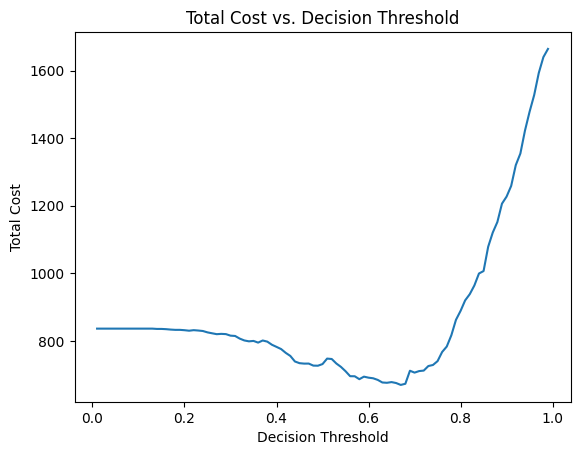

In [25]:
cb_column = 'A'
test_predictions_log['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log, best_pipeline_log_reg, y,cb_column,y_predicted_proba_col_name="y_predicted_proba_log" )

Decision Threshold: 0.01, Test cost/loss = 836.28
Decision Threshold: 0.02, Test cost/loss = 824.39
Decision Threshold: 0.03, Test cost/loss = 792.53
Decision Threshold: 0.04, Test cost/loss = 772.58
Decision Threshold: 0.05, Test cost/loss = 735.74
Decision Threshold: 0.06, Test cost/loss = 702.59
Decision Threshold: 0.07, Test cost/loss = 685.98
Decision Threshold: 0.08, Test cost/loss = 679.51
Decision Threshold: 0.09, Test cost/loss = 673.94
Decision Threshold: 0.10, Test cost/loss = 658.93
Decision Threshold: 0.11, Test cost/loss = 644.01
Decision Threshold: 0.12, Test cost/loss = 634.05
Decision Threshold: 0.13, Test cost/loss = 627.66
Decision Threshold: 0.14, Test cost/loss = 632.02
Decision Threshold: 0.15, Test cost/loss = 638.79
Decision Threshold: 0.16, Test cost/loss = 642.06
Decision Threshold: 0.17, Test cost/loss = 649.83
Decision Threshold: 0.18, Test cost/loss = 648.90
Decision Threshold: 0.19, Test cost/loss = 634.45
Decision Threshold: 0.20, Test cost/loss = 642.95


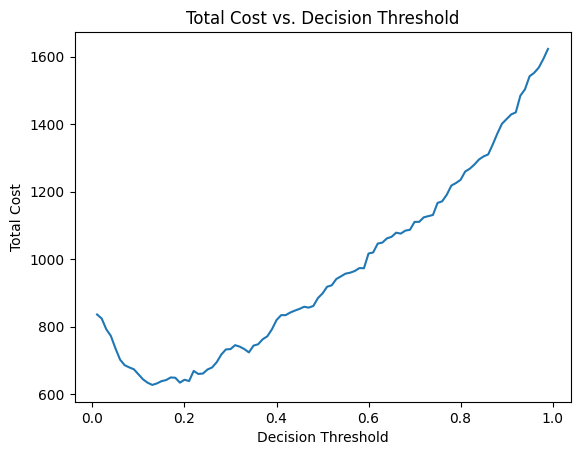

In [26]:
test_predictions_xgb['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb")

# E-AMC metric

In [27]:
test_predictions_log = add_eap_ep(
    train=train, 
    test=test_predictions_log, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="churn")
test_predictions_xgb = add_eap_ep(
    train=train, 
    test=test_predictions_xgb, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="churn")


c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [28]:
test_predictions_log

,row_number,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
8167,8168,713,Germany,Female,24,7,147687.24,1,1,1,121592.50,0,1,0,0.601333,0.000000,1,0.511968,0,7.215993,1.202666,0,0.615726,0.245043
4747,4748,663,Spain,Male,64,6,0.00,2,0,1,15876.52,0,1,0,0.000000,0.000000,1,0.830564,0,0.000000,0.000000,0,0.000000,0.000000
2090,2091,667,Spain,Male,39,9,0.00,2,1,0,68873.80,0,1,0,0.000000,0.000000,1,0.565203,0,0.000000,0.000000,0,0.000000,0.000000
3298,3299,558,Germany,Male,25,10,111363.10,2,1,0,197264.35,0,1,0,0.354861,0.000000,1,0.578175,0,4.258328,0.709721,0,0.410343,0.144606
9485,9486,850,Spain,Male,37,4,88141.10,1,1,0,109659.12,0,1,0,0.427838,0.000000,1,0.601580,0,5.134061,0.855677,0,0.514758,0.174344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,8380,434,Spain,Male,55,6,0.00,1,0,1,73562.05,1,1,1,0.000000,0.000000,1,0.764839,0,0.000000,0.000000,0,0.000000,0.000000
7223,7224,799,Germany,Male,31,9,154586.92,1,0,1,88604.89,1,0,1,0.705345,8.464146,0,0.489640,0,8.464146,1.410691,0,4.319759,6.739576
1046,1047,807,Spain,Female,42,1,0.00,1,1,0,16500.66,1,1,1,0.000000,0.000000,1,0.763371,0,0.000000,0.000000,0,0.000000,0.000000
1487,1488,710,Spain,Female,51,4,93656.95,1,0,1,141400.51,1,1,1,0.379735,4.556821,1,0.830794,0,4.556821,0.759470,0,0.771043,3.628369


In [29]:
test_predictions_xgb

,row_number,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
8167,8168,713,Germany,Female,24,7,147687.24,1,1,1,121592.50,0,0,0,0.601333,0.000000,0,0.302043,0,7.215993,1.202666,0,0.363257,0.245043
4747,4748,663,Spain,Male,64,6,0.00,2,0,1,15876.52,0,0,0,0.000000,0.000000,0,0.028987,0,0.000000,0.000000,0,0.000000,0.000000
2090,2091,667,Spain,Male,39,9,0.00,2,1,0,68873.80,0,0,0,0.000000,0.000000,0,0.021514,0,0.000000,0.000000,0,0.000000,0.000000
3298,3299,558,Germany,Male,25,10,111363.10,2,1,0,197264.35,0,0,0,0.354861,0.000000,0,0.066306,0,4.258328,0.709721,0,0.047059,0.144606
9485,9486,850,Spain,Male,37,4,88141.10,1,1,0,109659.12,0,0,0,0.427838,0.000000,0,0.032760,0,5.134061,0.855677,0,0.028032,0.174344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,8380,434,Spain,Male,55,6,0.00,1,0,1,73562.05,1,0,1,0.000000,0.000000,0,0.432260,0,0.000000,0.000000,0,0.000000,0.000000
7223,7224,799,Germany,Male,31,9,154586.92,1,0,1,88604.89,1,0,1,0.705345,8.464146,0,0.144389,0,8.464146,1.410691,0,7.242015,6.739576
1046,1047,807,Spain,Female,42,1,0.00,1,1,0,16500.66,1,1,1,0.000000,0.000000,1,0.676646,0,0.000000,0.000000,0,0.000000,0.000000
1487,1488,710,Spain,Female,51,4,93656.95,1,0,1,141400.51,1,0,1,0.379735,4.556821,0,0.205349,0,4.556821,0.759470,0,3.621084,3.628369


In [30]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

871.8594486635438
1497.296708062372
EAP :  0.4359297243317719
EP :  0.748648354031186


In [31]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

969.3141408945032
1497.296708062372
EAP :  0.4846570704472516
EP :  0.748648354031186


# mp at 50% threshold

In [32]:
test_predictions_log_2 = test.copy(deep=True)
test_predictions_log_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_2.drop(y, axis=1))
test_predictions_log_2["churn_encoded"] = fit_le.transform(test_predictions_log_2["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_2['A'] = impute.fit_transform(
    (test_predictions_log_2["balance"]*test_predictions_log_2["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
test_predictions_log_2['A'] = scaler.fit_transform(test_predictions_log_2['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_2['instance_cost'] = test_predictions_log_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_2[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_2['instance_cost'].sum()/len(test_predictions_log_2))

Test cost/loss = -469.
 total cost/loss average :  -0.2343193473270034


In [33]:
test_predictions_xgb_2 = test.copy(deep=True)
test_predictions_xgb_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_2.drop(y, axis=1))
test_predictions_xgb_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_2["exited"])

# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_2['A'] = impute.fit_transform(
    (test_predictions_xgb_2["balance"]*test_predictions_xgb_2["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions_xgb_2['A'] = scaler.fit_transform(test_predictions_xgb_2['A'].values.reshape(-1, 1))

# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_2['instance_cost'] = test_predictions_xgb_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_2[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_2['instance_cost'].sum()/len(test_predictions_xgb_2))

Test cost/loss = -761.
 total cost/loss average :  -0.38028917554745706


# MP-metric

Decision Threshold: 0.01, Test cost/loss = -558.54


Decision Threshold: 0.02, Test cost/loss = -558.54
Decision Threshold: 0.03, Test cost/loss = -558.54
Decision Threshold: 0.04, Test cost/loss = -558.54
Decision Threshold: 0.05, Test cost/loss = -558.54
Decision Threshold: 0.06, Test cost/loss = -558.54
Decision Threshold: 0.07, Test cost/loss = -558.54
Decision Threshold: 0.08, Test cost/loss = -558.54
Decision Threshold: 0.09, Test cost/loss = -558.54
Decision Threshold: 0.10, Test cost/loss = -558.54
Decision Threshold: 0.11, Test cost/loss = -558.54
Decision Threshold: 0.12, Test cost/loss = -558.54
Decision Threshold: 0.13, Test cost/loss = -558.54
Decision Threshold: 0.14, Test cost/loss = -557.66
Decision Threshold: 0.15, Test cost/loss = -557.66
Decision Threshold: 0.16, Test cost/loss = -556.93
Decision Threshold: 0.17, Test cost/loss = -555.72
Decision Threshold: 0.18, Test cost/loss = -554.91
Decision Threshold: 0.19, Test cost/loss = -554.91
Decision Threshold: 0.20, Test cost/loss = -553.89
Decision Threshold: 0.21, Test

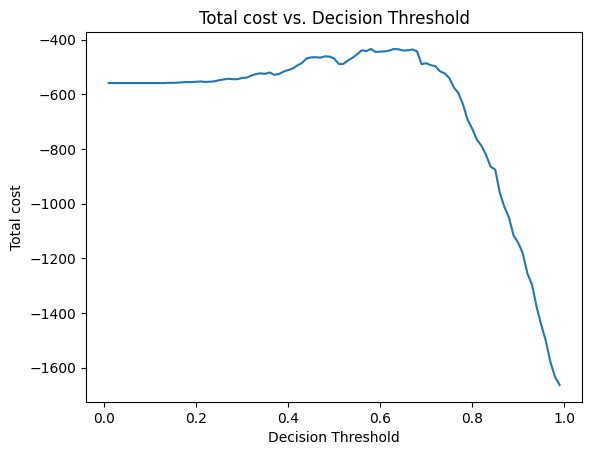

In [34]:
cb_column = 'A'
test_predictions_log_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_2, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type= 'churn_2' )

Decision Threshold: 0.01, Test cost/loss = -558.54
Decision Threshold: 0.02, Test cost/loss = -546.65
Decision Threshold: 0.03, Test cost/loss = -516.82
Decision Threshold: 0.04, Test cost/loss = -499.08
Decision Threshold: 0.05, Test cost/loss = -462.82
Decision Threshold: 0.06, Test cost/loss = -431.72
Decision Threshold: 0.07, Test cost/loss = -418.35
Decision Threshold: 0.08, Test cost/loss = -417.36
Decision Threshold: 0.09, Test cost/loss = -416.35
Decision Threshold: 0.10, Test cost/loss = -404.15
Decision Threshold: 0.11, Test cost/loss = -391.19
Decision Threshold: 0.12, Test cost/loss = -384.99
Decision Threshold: 0.13, Test cost/loss = -382.18
Decision Threshold: 0.14, Test cost/loss = -390.29
Decision Threshold: 0.15, Test cost/loss = -401.87
Decision Threshold: 0.16, Test cost/loss = -409.47
Decision Threshold: 0.17, Test cost/loss = -421.95
Decision Threshold: 0.18, Test cost/loss = -422.50
Decision Threshold: 0.19, Test cost/loss = -409.62
Decision Threshold: 0.20, Test 

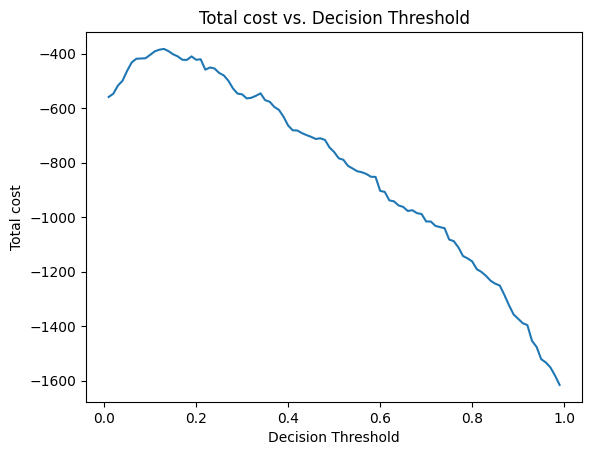

In [35]:
test_predictions_xgb_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'churn_2')

# emp metric


In [36]:
test_predictions_log_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="churn_2")
test_predictions_xgb_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="churn_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [37]:
print(test_predictions_log_2['EAP'].sum())
print(test_predictions_log_2['EP'].sum())


print('EAP : ', test_predictions_log_2['EAP'].sum()/len(test_predictions_log_2))
print('EP : ', test_predictions_log_2['EP'].sum()/len(test_predictions_log_2))

-649.0958474024002
-1440.7071173463942
EAP :  -0.3245479237012001
EP :  -0.7203535586731971


In [38]:
print(test_predictions_xgb_2['EAP'].sum())
print(test_predictions_xgb_2['EP'].sum())


print('EAP : ', test_predictions_xgb_2['EAP'].sum()/len(test_predictions_xgb_2))
print('EP : ', test_predictions_xgb_2['EP'].sum()/len(test_predictions_xgb_2))

-826.2261453701418
-1440.7071173463942
EAP :  -0.4131130726850709
EP :  -0.7203535586731971


# cost curves test

In [39]:
total_fp_log = 0

for i in range(0,2000):
    if test_predictions_log['churn_encoded'].iloc[i] == 0 and test_predictions_log['y_predicted'].iloc[i]==1:
        total_fp_log += test_predictions_log['FP'].iloc[i]
    else:
        total_fp_log += 0

print(total_fp_log)

average_fp_log = total_fp_log/2000
print( average_fp_log)

641.4384865061088
0.3207192432530544


In [40]:
total_fn_log = 0

for i in range(0,2000):
    if test_predictions_log['churn_encoded'].iloc[i] == 1 and test_predictions_log['y_predicted'].iloc[i]==0:
        total_fn_log += test_predictions_log['FN'].iloc[i]
    else:
        total_fn_log += 0

print(total_fn_log)

average_fn_log = total_fn_log/2000
print( average_fn_log)

89.94902629740177
0.044974513148700886


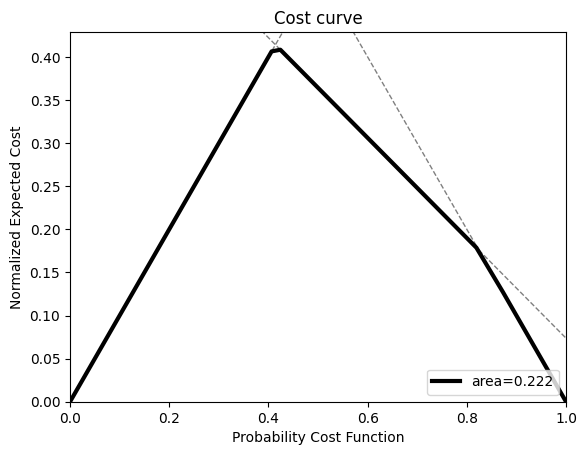

In [41]:
cost_fn_log = average_fn_log
# C(+|-)
cost_fp_log = average_fp_log

# Ground truth
truth = test_predictions_log['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log) / (thresholds*cost_fn_log + (1-thresholds)*cost_fp_log)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [42]:
total_fp_xgb = 0

for i in range(0,2000):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 0 and test_predictions_xgb['y_predicted'].iloc[i]==1:
        total_fp_xgb += test_predictions_xgb['FP'].iloc[i]
    else:
        total_fp_xgb += 0

print(total_fp_xgb)

average_fp_xgb = total_fp_xgb/2000
print( average_fp_xgb)

60.55478554002529
0.030277392770012648


In [43]:
total_fn_xgb = 0

for i in range(0,2000):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 1 and test_predictions_xgb['y_predicted'].iloc[i]==0:
        total_fn_xgb += test_predictions_xgb['FN'].iloc[i]
    else:
        total_fn_xgb += 0

print(total_fn_xgb)

average_fn_xgb = total_fn_xgb/2000
print( average_fn_xgb)

838.0833326462521
0.41904166632312606


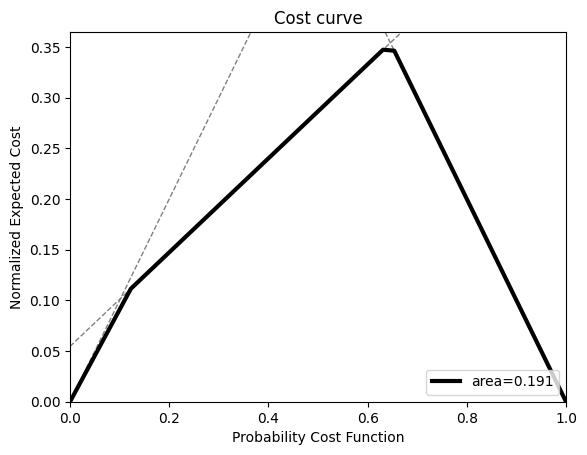

In [44]:
cost_fn_xgb = average_fn_xgb
# C(+|-)
cost_fp_xgb = average_fp_xgb

# Ground truth
truth = test_predictions_xgb['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb) / (thresholds*cost_fn_xgb + (1-thresholds)*cost_fp_xgb)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

# from here on we calculate the amc, e-amc, mp and emp but with the fraud detection cost and benefit matrices

# total cost 50% decision threshold

In [45]:
test_predictions_log_fraud = test.copy(deep=True)
test_predictions_log_fraud["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_fraud.drop(y, axis=1))
test_predictions_log_fraud["churn_encoded"] = fit_le.transform(test_predictions_log_fraud["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_fraud['A'] = impute.fit_transform(
    (test_predictions_log_fraud["balance"]*test_predictions_log_fraud["credit_score"]*2000).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
test_predictions_log_fraud['A'] = scaler.fit_transform(test_predictions_log_fraud['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_fraud['instance_cost'] = test_predictions_log_fraud.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_fraud["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_fraud["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_fraud[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_fraud['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_fraud['instance_cost'].sum()/len(test_predictions_log_fraud))

Test cost/loss = 1043.
 total cost/loss average :  0.5215018739380479


In [46]:
test_predictions_xgb_fraud = test.copy(deep=True)
test_predictions_xgb_fraud["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_fraud.drop(y, axis=1))
test_predictions_xgb_fraud["churn_encoded"] = fit_le.transform(test_predictions_xgb_fraud["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_fraud['A'] = impute.fit_transform(
    (test_predictions_xgb_fraud["balance"]*test_predictions_xgb_fraud["credit_score"]*2000).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions_xgb_fraud['A'] = scaler.fit_transform(test_predictions_xgb_fraud['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_fraud['instance_cost'] = test_predictions_xgb_fraud.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_fraud["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_fraud["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_fraud[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_fraud['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_fraud['instance_cost'].sum()/len(test_predictions_xgb_fraud))

Test cost/loss = 87.
 total cost/loss average :  0.04351746006943013


# amc metric

Decision Threshold: 0.01, Test cost/loss = 1593.00
Decision Threshold: 0.02, Test cost/loss = 1593.00
Decision Threshold: 0.03, Test cost/loss = 1593.00
Decision Threshold: 0.04, Test cost/loss = 1593.00
Decision Threshold: 0.05, Test cost/loss = 1593.00
Decision Threshold: 0.06, Test cost/loss = 1593.00
Decision Threshold: 0.07, Test cost/loss = 1593.00
Decision Threshold: 0.08, Test cost/loss = 1593.00
Decision Threshold: 0.09, Test cost/loss = 1591.00
Decision Threshold: 0.10, Test cost/loss = 1591.00
Decision Threshold: 0.11, Test cost/loss = 1591.00
Decision Threshold: 0.12, Test cost/loss = 1589.00
Decision Threshold: 0.13, Test cost/loss = 1587.00
Decision Threshold: 0.14, Test cost/loss = 1584.00
Decision Threshold: 0.15, Test cost/loss = 1581.00
Decision Threshold: 0.16, Test cost/loss = 1579.00
Decision Threshold: 0.17, Test cost/loss = 1573.00
Decision Threshold: 0.18, Test cost/loss = 1571.00
Decision Threshold: 0.19, Test cost/loss = 1564.00
Decision Threshold: 0.20, Test 

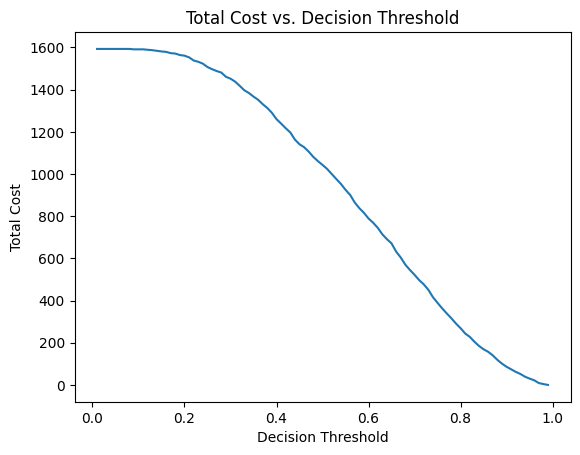

In [47]:
cb_column = 'A'
test_predictions_log_fraud['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_fraud.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log_fraud, best_pipeline_log_reg, y,cb_column,y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud' )

Decision Threshold: 0.01, Test cost/loss = 1577.00
Decision Threshold: 0.02, Test cost/loss = 1443.00
Decision Threshold: 0.03, Test cost/loss = 1262.00
Decision Threshold: 0.04, Test cost/loss = 1147.00
Decision Threshold: 0.05, Test cost/loss = 1043.00
Decision Threshold: 0.06, Test cost/loss = 952.00
Decision Threshold: 0.07, Test cost/loss = 885.00
Decision Threshold: 0.08, Test cost/loss = 819.00
Decision Threshold: 0.09, Test cost/loss = 766.01
Decision Threshold: 0.10, Test cost/loss = 712.01
Decision Threshold: 0.11, Test cost/loss = 668.01
Decision Threshold: 0.12, Test cost/loss = 628.01
Decision Threshold: 0.13, Test cost/loss = 589.01
Decision Threshold: 0.14, Test cost/loss = 561.01
Decision Threshold: 0.15, Test cost/loss = 530.01
Decision Threshold: 0.16, Test cost/loss = 497.01
Decision Threshold: 0.17, Test cost/loss = 464.01
Decision Threshold: 0.18, Test cost/loss = 449.01
Decision Threshold: 0.19, Test cost/loss = 418.01
Decision Threshold: 0.20, Test cost/loss = 40

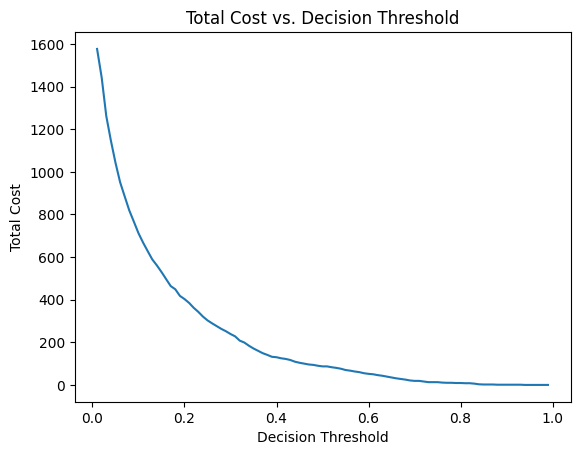

In [48]:
test_predictions_xgb_fraud['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_fraud.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb_fraud, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type = 'fraud')

# e-amc metric

In [49]:
test_predictions_log_fraud = add_eap_ep(
    train=train, 
    test=test_predictions_log_fraud, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label=1, 
    instance_dependent_cost_type="fraud")
test_predictions_xgb_fraud = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_fraud, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [50]:
print(test_predictions_log_fraud['EAP'].sum())
print(test_predictions_log_fraud['EP'].sum())


print('EAP : ', test_predictions_log_fraud['EAP'].sum()/len(test_predictions_log_fraud))
print('EP : ', test_predictions_log_fraud['EP'].sum()/len(test_predictions_log_fraud))

937.4672899946789
324.62903768295394
EAP :  0.4687336449973395
EP :  0.16231451884147696


In [51]:
print(test_predictions_xgb_fraud['EAP'].sum())
print(test_predictions_xgb_fraud['EP'].sum())


print('EAP : ', test_predictions_xgb_fraud['EAP'].sum()/len(test_predictions_xgb_fraud))
print('EP : ', test_predictions_xgb_fraud['EP'].sum()/len(test_predictions_xgb_fraud))

235.72546977796935
324.62903768295394
EAP :  0.11786273488898467
EP :  0.16231451884147696


# mp at 50% threshold

In [52]:
test_predictions_log_fraud_2 = test.copy(deep=True)
test_predictions_log_fraud_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_fraud_2.drop(y, axis=1))
test_predictions_log_fraud_2["churn_encoded"] = fit_le.transform(test_predictions_log_fraud_2["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_fraud_2['A'] = impute.fit_transform(
    (test_predictions_log_fraud_2["balance"]*test_predictions_log_fraud_2["credit_score"]*2000).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
test_predictions_log_fraud_2['A'] = scaler.fit_transform(test_predictions_log_fraud_2['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_fraud_2['instance_cost'] = test_predictions_log_fraud_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_fraud_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_fraud_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_fraud_2[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_fraud_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_fraud_2['instance_cost'].sum()/len(test_predictions_log_fraud_2))

Test cost/loss = -666.
 total cost/loss average :  -0.33300187393804787


In [53]:
test_predictions_xgb_fraud_2 = test.copy(deep=True)
test_predictions_xgb_fraud_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_fraud_2.drop(y, axis=1))
test_predictions_xgb_fraud_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_fraud_2["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_fraud_2['A'] = impute.fit_transform(
    (test_predictions_xgb_fraud_2["balance"]*test_predictions_xgb_fraud_2["credit_score"]*2000).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions_xgb_fraud_2['A'] = scaler.fit_transform(test_predictions_xgb_fraud_2['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_fraud_2['instance_cost'] = test_predictions_xgb_fraud_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_fraud_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_fraud_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_fraud_2[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_fraud_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_fraud_2['instance_cost'].sum()/len(test_predictions_xgb_fraud_2))

Test cost/loss = 109.
 total cost/loss average :  0.05448253993056987


# mp metric

Decision Threshold: 0.01, Test cost/loss = -1186.00
Decision Threshold: 0.02, Test cost/loss = -1186.00
Decision Threshold: 0.03, Test cost/loss = -1186.00
Decision Threshold: 0.04, Test cost/loss = -1186.00
Decision Threshold: 0.05, Test cost/loss = -1186.00
Decision Threshold: 0.06, Test cost/loss = -1186.00
Decision Threshold: 0.07, Test cost/loss = -1186.00
Decision Threshold: 0.08, Test cost/loss = -1186.00
Decision Threshold: 0.09, Test cost/loss = -1185.00
Decision Threshold: 0.10, Test cost/loss = -1185.00
Decision Threshold: 0.11, Test cost/loss = -1185.00
Decision Threshold: 0.12, Test cost/loss = -1183.00
Decision Threshold: 0.13, Test cost/loss = -1181.00
Decision Threshold: 0.14, Test cost/loss = -1178.00
Decision Threshold: 0.15, Test cost/loss = -1175.00
Decision Threshold: 0.16, Test cost/loss = -1173.00
Decision Threshold: 0.17, Test cost/loss = -1167.00
Decision Threshold: 0.18, Test cost/loss = -1165.00
Decision Threshold: 0.19, Test cost/loss = -1159.00
Decision Thr

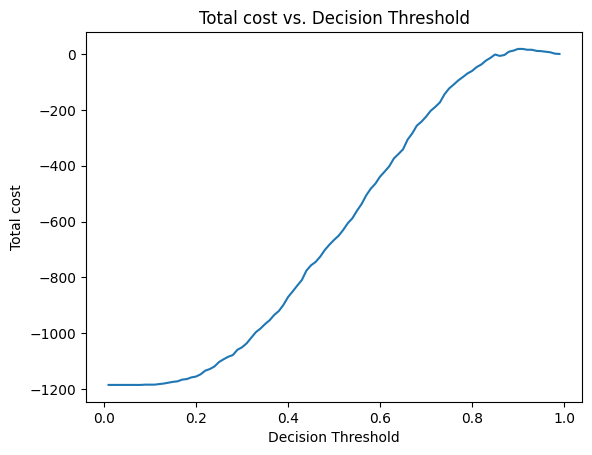

In [54]:
cb_column = 'A'
test_predictions_log_fraud_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_fraud_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_fraud_2, best_pipeline_log_reg, y,cb_column,y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud_2' )

Decision Threshold: 0.01, Test cost/loss = -1170.00
Decision Threshold: 0.02, Test cost/loss = -1039.00
Decision Threshold: 0.03, Test cost/loss = -861.00
Decision Threshold: 0.04, Test cost/loss = -752.00
Decision Threshold: 0.05, Test cost/loss = -653.00
Decision Threshold: 0.06, Test cost/loss = -565.00
Decision Threshold: 0.07, Test cost/loss = -501.00
Decision Threshold: 0.08, Test cost/loss = -444.00
Decision Threshold: 0.09, Test cost/loss = -397.01
Decision Threshold: 0.10, Test cost/loss = -346.01
Decision Threshold: 0.11, Test cost/loss = -307.01
Decision Threshold: 0.12, Test cost/loss = -271.01
Decision Threshold: 0.13, Test cost/loss = -237.01
Decision Threshold: 0.14, Test cost/loss = -215.01
Decision Threshold: 0.15, Test cost/loss = -192.01
Decision Threshold: 0.16, Test cost/loss = -166.01
Decision Threshold: 0.17, Test cost/loss = -140.01
Decision Threshold: 0.18, Test cost/loss = -127.01
Decision Threshold: 0.19, Test cost/loss = -100.01
Decision Threshold: 0.20, Tes

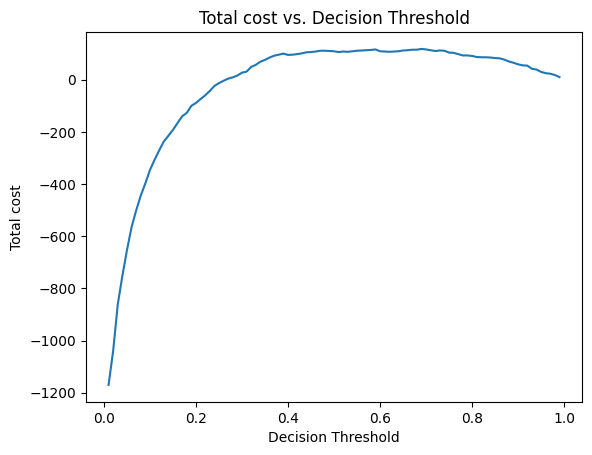

In [55]:
test_predictions_xgb_fraud_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_fraud_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_fraud_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type = 'fraud_2')

# emp-metric

In [56]:
test_predictions_log_fraud_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_fraud_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label=1, 
    instance_dependent_cost_type="fraud_2")
test_predictions_xgb_fraud_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_fraud_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [57]:
print(test_predictions_log_fraud_2['EAP'].sum())
print(test_predictions_log_fraud_2['EP'].sum())


print('EAP : ', test_predictions_log_fraud_2['EAP'].sum()/len(test_predictions_log_fraud_2))
print('EP : ', test_predictions_log_fraud_2['EP'].sum()/len(test_predictions_log_fraud_2))

-622.2632623426445
-241.70278768295395
EAP :  -0.31113163117132225
EP :  -0.12085139384147697


In [58]:
print(test_predictions_xgb_fraud_2['EAP'].sum())
print(test_predictions_xgb_fraud_2['EP'].sum())


print('EAP : ', test_predictions_xgb_fraud_2['EAP'].sum()/len(test_predictions_xgb_fraud_2))
print('EP : ', test_predictions_xgb_fraud_2['EP'].sum()/len(test_predictions_xgb_fraud_2))

-31.8064035481342
-241.70278768295395
EAP :  -0.0159032017740671
EP :  -0.12085139384147697


# cost curves

In [59]:
total_fp_log_2 = 0

for i in range(0,2000):
    if test_predictions_log_fraud['churn_encoded'].iloc[i] == 0 and test_predictions_log_fraud['y_predicted'].iloc[i]==1:
        total_fp_log_2 += test_predictions_log_fraud['FP'].iloc[i]
    else:
        total_fp_log_2 += 0

print(total_fp_log_2)

average_fp_log_2 = total_fp_log_2/2000
print( average_fp_log_2)

1043
0.5215


In [60]:
total_fn_log_2 = 0

for i in range(0,2000):
    if test_predictions_log_fraud['churn_encoded'].iloc[i] == 1 and test_predictions_log_fraud['y_predicted'].iloc[i]==0:
        total_fn_log_2 += test_predictions_log_fraud['FN'].iloc[i]
    else:
        total_fn_log_2 += 0

print(total_fn_log_2)

average_fn_log_2 = total_fn_log_2/2000
print( average_fn_log_2)

0.0037478760957250744
1.8739380478625373e-06


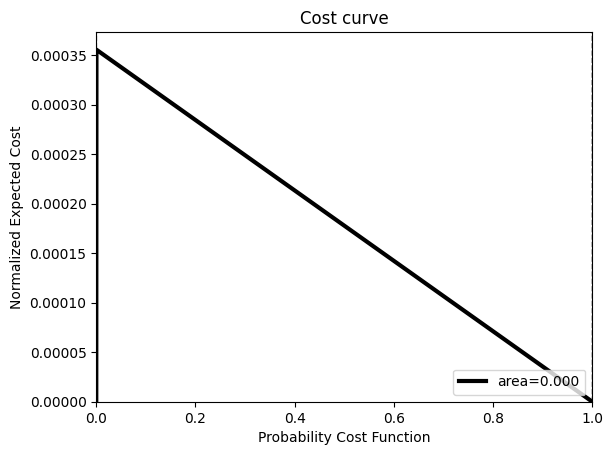

In [61]:
cost_fn_log_2 = average_fn_log_2
# C(+|-)
cost_fp_log_2 = average_fp_log_2

# Ground truth
truth = test_predictions_log_fraud['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log_fraud['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log_2) / (thresholds*cost_fn_log_2 + (1-thresholds)*cost_fp_log_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [62]:
total_fp_xgb_2 = 0

for i in range(0,2000):
    if test_predictions_xgb_fraud['churn_encoded'].iloc[i] == 0 and test_predictions_xgb_fraud['y_predicted'].iloc[i]==1:
        total_fp_xgb_2 += test_predictions_xgb_fraud['FP'].iloc[i]
    else:
        total_fp_xgb_2 += 0

print(total_fp_xgb_2)

average_fp_xgb_2 = total_fp_xgb_2/2000
print( average_fp_xgb_2)

87
0.0435


In [63]:
total_fn_xgb_2 = 0

for i in range(0,2000):
    if test_predictions_xgb_fraud['churn_encoded'].iloc[i] == 1 and test_predictions_xgb_fraud['y_predicted'].iloc[i]==0:
        total_fn_xgb_2 += test_predictions_xgb_fraud['FN'].iloc[i]
    else:
        total_fn_xgb_2 += 0

print(total_fn_xgb_2)

average_fn_xgb_2 = total_fn_xgb_2/2000
print( average_fn_xgb_2)

0.03492013886026051
1.7460069430130257e-05


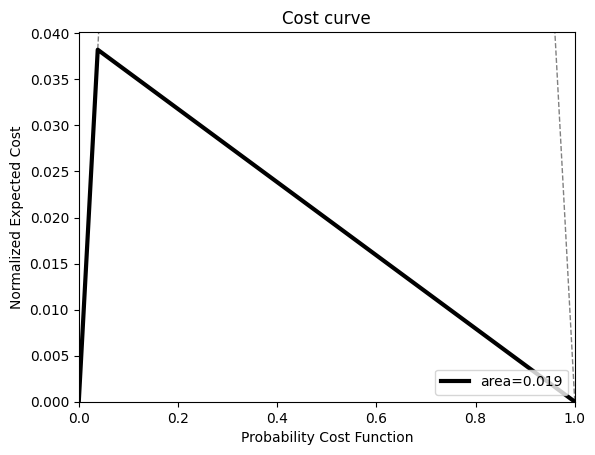

In [64]:
#C(-|+)
cost_fn_xgb_2 = average_fn_xgb_2
# C(+|-)
cost_fp_xgb_2 = average_fp_xgb_2

# Ground truth
truth = test_predictions_xgb_fraud['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb_fraud['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb_2) / (thresholds*cost_fn_xgb_2 + (1-thresholds)*cost_fp_xgb_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()